<a href="https://colab.research.google.com/github/enigmatized/NoGambleNoFuture/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What I want to do is,
find correlation between volume and SD moves in price diff.
Also I want to start looking at 1min price diff and compare that on the 5min, 15min.
To find a pattern within that to trade on the 15.

Eventually I want to add in trading events.


1. See if the limit of low helps
2. See if the time frames on lower level help, not sure how that should be done exactly?
3. Also volume spikes, this is a weird one because there is an event spike that is not being considered here which I think is really important
4. Data

In [2]:
from collections import defaultdict
import requests
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime, timedelta, time
from urllib.error import HTTPError
import statistics

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#
cur_working_directiory = os.getcwd()
# Change 
os.chdir("../../Data/")


CSVfiles = []
for file in os.listdir("./"):
  if file.endswith(".csv"):
    CSVfiles.append(file)
print(CSVfiles)


unixTimeConverter = lambda x : (datetime.fromtimestamp(x)).strftime('%Y-%m-%d %H:%M:%S')
unixTimeConverterNoDateJustTime = lambda x: (datetime.fromtimestamp(x) - timedelta(hours=4)).time()


allDfs = []


for x in CSVfiles:

  dfTemp = pd.read_csv(x)
  dfTemp['estTime']  = dfTemp['time'].apply(unixTimeConverter)
  dfTemp['timeOnly'] = dfTemp['time'].apply(unixTimeConverterNoDateJustTime)

  dfTemp['candleHeight']  = dfTemp.apply( lambda row:    max(row['open'],  row['close']) - min(row['open'],  row['close']), axis = 1 )
  allDfs.append(dfTemp)

df = allDfs[0]
#This is for generating if profit
for i in range(1, 15):
  df['P/L' +str(i) +'Short_']  = ( df['close'] - df['close'].shift(-i) )
  df['P/L' +str(i) +'Long_']  =  (  df['close'].shift(-i) - df['close']     )
  df['P/L' +str(i) +'Short']  = ( df['close'] - df['close'].shift(i) )
  df['P/L' +str(i) +'Long']  =  (  df['close'].shift(i) - df['close']     )

df = df.dropna()


os.chdir(cur_working_directiory)

df.head()

['OANDA EURUSD, 5(2).csv']


,time,open,high,low,close,Volume,Volume MA,estTime,timeOnly,candleHeight,...,P/L12Short,P/L12Long,P/L13Short_,P/L13Long_,P/L13Short,P/L13Long,P/L14Short_,P/L14Long_,P/L14Short,P/L14Long
14,1681399800,1.10544,1.10549,1.10522,1.10528,290,545.80,2023-04-13 11:30:00,07:30:00,0.00016,...,-0.00052,0.00052,-0.00004,0.00004,-0.00008,0.00008,0.00021,-0.00021,0.00052,-0.00052
15,1681400100,1.10528,1.10590,1.10528,1.10572,343,523.55,2023-04-13 11:35:00,07:35:00,0.00044,...,0.00074,-0.00074,0.00065,-0.00065,-0.00008,0.00008,0.00066,-0.00066,0.00036,-0.00036
16,1681400400,1.10572,1.10594,1.10572,1.10580,350,503.60,2023-04-13 11:40:00,07:40:00,0.00008,...,0.00092,-0.00092,0.00074,-0.00074,0.00082,-0.00082,0.00042,-0.00042,0.00000,0.00000
17,1681400700,1.10580,1.10616,1.10574,1.10600,355,489.65,2023-04-13 11:45:00,07:45:00,0.00020,...,0.00126,-0.00126,0.00062,-0.00062,0.00112,-0.00112,0.00042,-0.00042,0.00102,-0.00102
18,1681401000,1.10600,1.10602,1.10520,1.10522,392,477.50,2023-04-13 11:50:00,07:50:00,0.00078,...,0.00053,-0.00053,-0.00036,0.00036,0.00048,-0.00048,-0.00040,0.00040,0.00034,-0.00034


In [3]:
d_counts_average_vol            = defaultdict(list)
d_counts_average_highLow_diff   = defaultdict(list)


closeOpenDeltaList = []
closeOpenDeltaList_ = []
openLowDeltaList = []
highLowDeltaList = []

for index, row in df.iterrows():
  closeOpenDeltaList.append(abs(row['close'] - row['open']))
  closeOpenDeltaList_.append(row['close'] - row['open'])
  openLowDeltaList.append(abs(row['open'] - row['low']))
  highLowDeltaList.append(row['high'] - row['low'])


df1 = pd.DataFrame({'closeOpenDelta': closeOpenDeltaList, 'CloseOpenDelta_': closeOpenDeltaList_, 'openLowDelta': openLowDeltaList, 'highLowDelta': highLowDeltaList})

# df2 = pd.concat([df, df1])

df2 = pd.concat([df.reset_index(drop=True), df1.reset_index(drop=True)], axis=1)
print("mnath should add up")
print(df.shape)
print(df1.shape)
print(df2.shape)
df= df2

for index, row in df.iterrows():
  #put volumes in d
  time_  = str(row['timeOnly'])
  volume = row['Volume']
  d_counts_average_vol[str(time_)].append(volume)


  #Collecting, using a dictionary of lists to collect the price deltas for each time
  price_delta = row['closeOpenDelta']
  d_counts_average_highLow_diff[str(time_)].append(price_delta)

df.head()

###############################################
##THIS use to be seperate cells, but now I just combined them
##
################################################
import statistics

std_values_with_time_as_keys = {}
mean_values_with_time_as_keys = {}

#for volume
std_values_with_time_as_keys_volume = {}
mean_values_with_time_as_keys_volume = {}

for k , v in d_counts_average_highLow_diff.items():

  # Calculate mean and standard deviation of the sample for price delta
  mean = statistics.mean(v)
  std_dev = statistics.stdev(v)
  std_values_with_time_as_keys[k] = std_dev
  mean_values_with_time_as_keys[k] = mean

for k , v in d_counts_average_vol.items():
  # Calculate mean and standard deviation of the sample of volume
  mean__ = statistics.mean(v)
  std_dev__ = statistics.stdev(v)
  std_values_with_time_as_keys_volume[k] = std_dev__
  mean_values_with_time_as_keys_volume[k] = mean__


z_score_list = []
z_score_volume_list = []

for index, row in df.iterrows():
  time_  = str(row['timeOnly'])
  mean_ = mean_values_with_time_as_keys[time_]
  std_ = std_values_with_time_as_keys[time_]

  cur_val = row['closeOpenDelta']
  z_score_list.append(( cur_val - mean)/ std_)
  # row['z-score'] = (row['closeOpenDelta'] - mean)/ std_
  
  mean_ = mean_values_with_time_as_keys_volume[time_]
  std_ = std_values_with_time_as_keys_volume[time_]
  df.loc[index, 'z-score-volume'] = (row['Volume'] - mean)/ std_

df['z-score']= z_score_list 
# df['z-score-volume']= 


df.head(1)


mnath should add up
(16751, 66)
(16751, 4)
(16751, 70)


,time,open,high,low,close,Volume,Volume MA,estTime,timeOnly,candleHeight,...,P/L14Short_,P/L14Long_,P/L14Short,P/L14Long,closeOpenDelta,CloseOpenDelta_,openLowDelta,highLowDelta,z-score-volume,z-score
0,1681399800,1.10544,1.10549,1.10522,1.10528,290,545.8,2023-04-13 11:30:00,07:30:00,0.00016,...,0.00021,-0.00021,0.00052,-0.00052,0.00016,-0.00016,0.00022,0.00027,1.914775,-0.123742


In [23]:
""" 
This is a split test, curious to see if having a 
low openLowDelta, along with a 4+ z-score, will
increase a higher profitablity rate.
"""

totalProfShort = defaultdict(float)
totalProfLong  = defaultdict(float)
totalPro       = defaultdict(float)

#Note this is actually shorting, I am doing the opposite of the 
#Large directional move, hence mean reversion
totalProfLongList = defaultdict(list)
#Comparing this 
#to see if only buy when the open and low are close together
totalProfLongListWithLowOpenLowDelata = defaultdict(list)
totalProfLongWithLowOpenLowDelta      = defaultdict(float)
#
#to see if only buy when the open and low are FAR away
totalProfLongListWithHighOpenLowDelata = defaultdict(list)
totalProfLongWithHighOpenLowDelta      = defaultdict(float)
#
#volume filter
totalProfLongListWithHighVolume = defaultdict(list)
totalProfLongWithHighVolume      = defaultdict(float)
totalProfLongListWithLowVolume = defaultdict(list)
totalProfLongWithLowVolume      = defaultdict(float)
#to see if only buy when the open and low are close together
totalProfLongListWithLowOpenLowDelata_filter_big_moves = defaultdict(list)
totalProfLongWithLowOpenLowDelta_filter_big_moves      = defaultdict(float)
# filter for only the largest moves
totalProfLongListWithLowOpenLowDelata_filter_most_moves = defaultdict(list)
totalProfLongWithLowOpenLowDelta_filter_most_moves      = defaultdict(float)


# With Stop Losses
totalProfLongListStopLoss = defaultdict(list)
totalProfLongStopLoss  = defaultdict(float)



# allBigSDMoves
for index, row in df.iterrows():
  if row['z-score'] >= 3:
    if row['CloseOpenDelta_'] > 0:
      for i in range(1,15):
        lookup = 'P/L' + str(i) +'Short'
        totalProfLong[lookup] +=row[lookup]
        totalProfLongList[lookup].append(row[lookup])
        #print(row['CloseOpenDelta_'])
        if row['openLowDelta'] <= 0.00006:
          totalProfLongWithLowOpenLowDelta[lookup] +=row[lookup]
          totalProfLongListWithLowOpenLowDelata[lookup].append(row[lookup])
        if row['openLowDelta'] > 0.00006:
          totalProfLongWithHighOpenLowDelta[lookup] +=row[lookup]
          totalProfLongListWithHighOpenLowDelata[lookup].append(row[lookup])
        if row['z-score-volume'] >= 2:
          totalProfLongWithHighVolume[lookup] +=row[lookup]
          totalProfLongListWithHighVolume[lookup].append(row[lookup])
        if row['z-score'] <= 4:
          totalProfLongListWithLowOpenLowDelata_filter_big_moves[lookup].append(row[lookup])
          totalProfLongWithLowOpenLowDelta_filter_big_moves[lookup] +=row[lookup]
        if row['z-score'] >= 4.2:
          totalProfLongWithLowOpenLowDelta_filter_most_moves[lookup] +=row[lookup]
          totalProfLongListWithLowOpenLowDelata_filter_most_moves[lookup].append(row[lookup])
  if row['z-score'] >= 3:
    if row['CloseOpenDelta_'] > 0:
      bought_value = row['close']
      for i in range(1,10):
        stopLoss = 0.003
        lookup = 'P/L' + str(i) +'Short'
        if df.iloc[index+i]['high'] - bought_value > stopLoss:
          totalProfLongStopLoss[lookup] -= stopLoss
          totalProfLongListStopLoss[lookup].append(-stopLoss)
          break
        else:
          totalProfLongStopLoss[lookup] += row[lookup]
          totalProfLongListStopLoss[lookup].append(row[lookup])



  
      


###################
#Print Stats

def whoIsLargest(a,b,c,d):
  if a > b and a > c and a > d:
    return "no filter"
  if b > a and b > c and b > d:
    return "small open low delta"
  if c > a and c > b and c > d:
    return "large open low delta"
  if d > a and d > b and d > c:
    return "high volume"
  return "all are equal"
def whoIsSmallest(a,b,c,d):
  if a < b and a < c and a < d:
    return "no filter"
  if b < a and b < c and b < d:
    return "small open low delta"
  if c < a and c < b and c < d:
    return "large open low delta"
  if d < a and d < b and d < c:
    return "high volume"
  return "all are equal"
  
# for k, v in totalProfLong.items():
#   print(k, "any z-score", v, "filtered out with only low open low delta", totalProfLongWithLowOpenLowDelta[k], "diff", v - totalProfLongWithLowOpenLowDelta[k])

#Note total doesn't seem to matter much because the filters force less trades
for k, v in totalProfLongList.items():
  print("--------------------")
  print(k, "first is no filter, second is filtered out with only low open low delta")
  print(  "mean",  sum(v)/len(v), "std", statistics.stdev(v), "median", statistics.median(v), "max", max(v), "min", min(v), "total", sum(v))
  print(  "mean",  sum(totalProfLongListWithLowOpenLowDelata[k])/len(totalProfLongListWithLowOpenLowDelata[k]), "std", statistics.stdev(totalProfLongListWithLowOpenLowDelata[k]), "median", statistics.median(totalProfLongListWithLowOpenLowDelata[k]), "max", max(totalProfLongListWithLowOpenLowDelata[k]), "min", min(totalProfLongListWithLowOpenLowDelata[k]), )
  print(  "mean",  sum(totalProfLongListWithHighOpenLowDelata[k])/len(totalProfLongListWithHighOpenLowDelata[k]), "std", statistics.stdev(totalProfLongListWithHighOpenLowDelata[k]), "median", statistics.median(totalProfLongListWithHighOpenLowDelata[k]), "max", max(totalProfLongListWithHighOpenLowDelata[k]), "min", min(totalProfLongListWithHighOpenLowDelata[k]))
  print(  "mean",  sum(totalProfLongListWithHighVolume[k])/len(totalProfLongListWithHighVolume[k]), "std", statistics.stdev(totalProfLongListWithHighVolume[k]), "median", statistics.median(totalProfLongListWithHighVolume[k]), "max", max(totalProfLongListWithHighVolume[k]), "min", min(totalProfLongListWithHighVolume[k]) )
  print( "mean",  sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k])/len(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "std", statistics.stdev(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "median", statistics.median(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "max", max(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "min", min(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]))
  print( "mean",  sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])/len(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "std", statistics.stdev(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "median", statistics.median(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "max", max(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "min", min(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]))
  if len(totalProfLongListStopLoss[k]) > 0 : print( "mean",  sum(totalProfLongListStopLoss[k])/len(totalProfLongListStopLoss[k]), "std", statistics.stdev(totalProfLongListStopLoss[k]), "median", statistics.median(totalProfLongListStopLoss[k]), "max", max(totalProfLongListStopLoss[k]), "min", min(totalProfLongListStopLoss[k]))
  # mean_ = whoIsLargest(sum(v)/len(v), sum(totalProfLongListWithLowOpenLowDelata[k])/len(totalProfLongListWithLowOpenLowDelata[k]), sum(totalProfLongListWithHighOpenLowDelata[k])/len(totalProfLongListWithHighOpenLowDelata[k]), sum(totalProfLongListWithHighVolume[k])/len(totalProfLongListWithHighVolume[k]))
  # std_  = whoIsSmallest(statistics.stdev(v), statistics.stdev(totalProfLongListWithLowOpenLowDelata[k]), statistics.stdev(totalProfLongListWithHighOpenLowDelata[k]), statistics.stdev(totalProfLongListWithHighVolume[k]))
  # print("winners", "---mean---" , mean_, "---std---", std_)
# 
# print(len(totalProfLongList))

#plots

                                                     
# "total", sum(totalProfLongListWithLowOpenLowDelata[k]) ,                
# "total", ,               
#  ,                      
# "total", sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]) 
# "total", sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])


import inspect

def print_variable_name(var):
    # Get the current frame
    current_frame = inspect.currentframe()

    # Get the caller's frame (the frame where the function is called)
    caller_frame = current_frame.f_back

    # Get the caller's local variables dictionary
    local_vars = caller_frame.f_locals

    # Find the variable name by searching for its value in the local variables
    var_name = [name for name, value in local_vars.items() if value is var][0]

    # Print the variable name and its value
    print(f"Variable name: {var_name}, Value: {var}")



--------------------
P/L1Short first is no filter, second is filtered out with only low open low delta
mean 0.0010175229357798068 std 0.0005462958701196758 median 0.0008799999999999919 max 0.0036399999999998656 min 0.0004199999999998649 total 0.11090999999999895
mean 0.0009596721311475488 std 0.0005380147681155001 median 0.0008399999999999519 max 0.0029799999999999827 min 0.00042000000000008697
mean 0.001091041666666635 std 0.0005535234896064485 median 0.0009549999999999281 max 0.0036399999999998656 min 0.0004199999999998649
mean 0.0010399999999999875 std 0.0005483974888939939 median 0.0008949999999998681 max 0.0036399999999998656 min 0.0004199999999998649
mean 0.0008640789473684168 std 0.0003993433865120095 median 0.0008150000000000102 max 0.0029799999999999827 min 0.0004199999999998649
mean 0.0014477777777777557 std 0.0007156510394433812 median 0.0011799999999999589 max 0.0036399999999998656 min 0.0006800000000000139
mean 0.0010175229357798068 std 0.0005462958701196758 median 0.00087

In [24]:
for k, v in totalProfLongList.items():
  print("--------------------")
  print(k, "first is no filter, second is filtered out with only low open low delta")
  print(  "total", sum(v))
  print(  "total", sum(totalProfLongListWithLowOpenLowDelata[k]), )
  print(  "total", sum(totalProfLongListWithHighOpenLowDelata[k]))
  print(   "total", sum(totalProfLongListWithHighVolume[k]) )
  print( "total", sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]))
  print(  "total", sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]))
  if len(totalProfLongListStopLoss[k]) > 0 : print( "total", sum(totalProfLongListStopLoss[k]))

--------------------
P/L1Short first is no filter, second is filtered out with only low open low delta
total 0.11090999999999895
total 0.05854000000000048
total 0.05236999999999847
total 0.1081599999999987
total 0.06566999999999967
total 0.0390899999999994
total 0.11090999999999895
--------------------
P/L2Short first is no filter, second is filtered out with only low open low delta
total 0.10890999999999873
total 0.05825000000000036
total 0.05065999999999837
total 0.10690999999999873
total 0.055509999999998616
total 0.04608000000000034
total 0.10890999999999873
--------------------
P/L3Short first is no filter, second is filtered out with only low open low delta
total 0.09553999999999974
total 0.049450000000000216
total 0.04608999999999952
total 0.09450999999999987
total 0.04151999999999978
total 0.04463000000000017
total 0.08955999999999975
--------------------
P/L4Short first is no filter, second is filtered out with only low open low delta
total 0.082819999999999
total 0.04796
tota

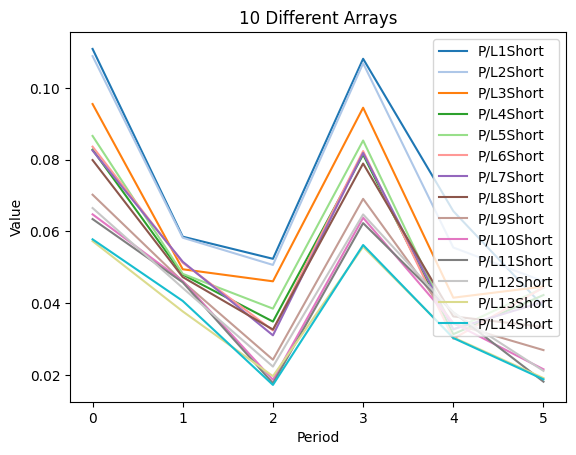

In [26]:
import numpy as np

colors = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
colors = plt.cm.tab20(np.linspace(0, 1, 15))

i = 0
# Plot each array with a different color
for k, v in totalProfLongList.items():

    t1 = sum(v)
    t2 = sum(totalProfLongListWithLowOpenLowDelata[k])
    t3 = sum(totalProfLongListWithHighOpenLowDelata[k])
    t4 = sum(totalProfLongListWithHighVolume[k])
    t5 = sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k])
    t6 = sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])    
    data = [t1, t2, t3, t4, t5, t6]
    plt.plot(data, color=colors[i], label=k)
    i += 1

# Customize the plot
plt.xlabel('Period')
plt.ylabel('Value')
plt.title('10 Different Arrays')
plt.legend()

# Show the plot
plt.show()

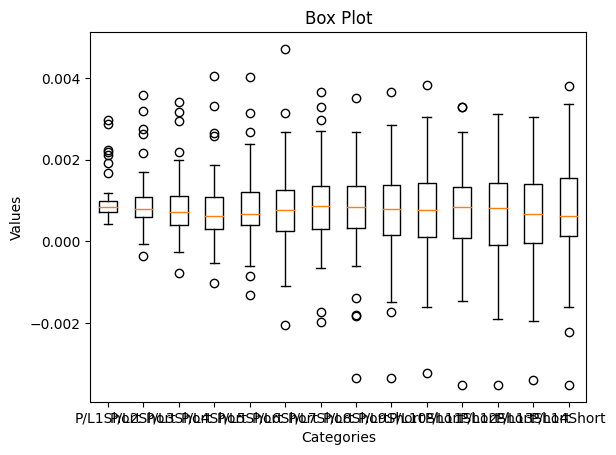

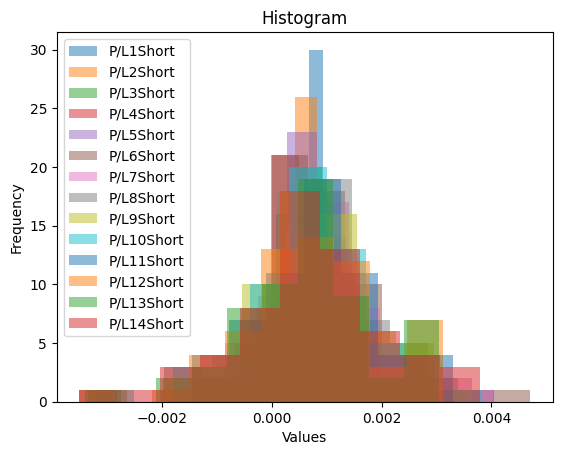

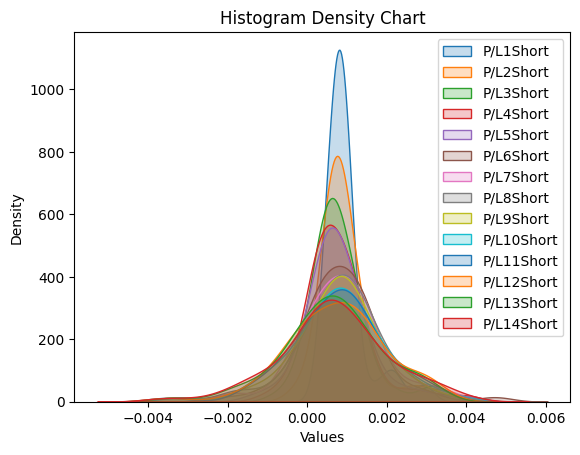

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


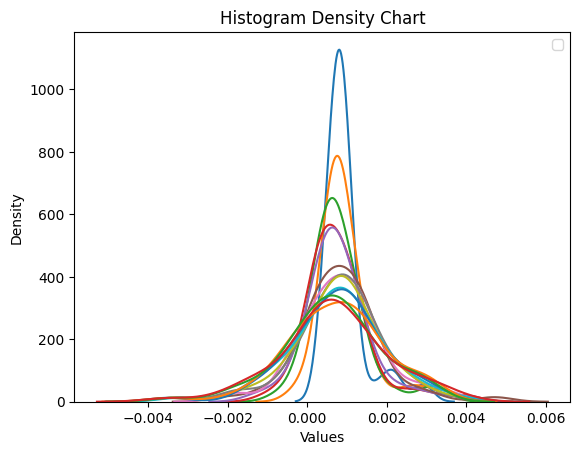

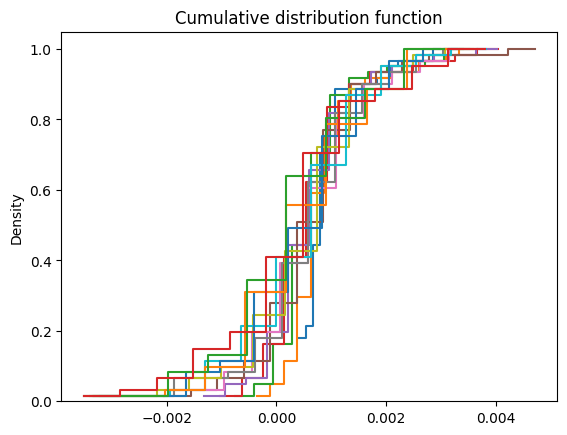

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = list(totalProfLongListWithLowOpenLowDelata.keys())
data = list(totalProfLongListWithLowOpenLowDelata.values())

# Create the box plot
plt.boxplot(data, labels=labels)

# Add a title and labels to the plot
plt.title('Box Plot')
plt.xlabel('Categories')
plt.ylabel('Values')

# Show the plot
plt.show()
###################
######Plotting Histograms
###################
for category, values in totalProfLongListWithLowOpenLowDelata.items():
    plt.hist(values, bins=10, alpha=0.5, label=category)

# Add a legend, title, and labels to the plot
plt.legend()
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()


# ######Plotting Histograms

for category, values in totalProfLongListWithLowOpenLowDelata.items():
    sns.kdeplot(values, label=category, shade=True)

# Add a legend, title, and labels to the plot
plt.legend()
plt.title('Histogram Density Chart')
plt.xlabel('Values')
plt.ylabel('Density')

# Show the plot
plt.show()

########
#Kernal Denisty Plot

# ######Plotting Histograms

for category, values in totalProfLongListWithLowOpenLowDelata.items():
    sns.kdeplot(values, common_norm=False)

# Add a legend, title, and labels to the plot
plt.legend()
plt.title('Histogram Density Chart')
plt.xlabel('Values')
plt.ylabel('Density')

# Show the plot
plt.show()

for category, values in totalProfLongListWithLowOpenLowDelata.items():
    sns.histplot(values, stat="density", element="step", fill=False, cumulative=True, common_norm=False);
plt.title("Cumulative distribution function");


In [ ]:
for i, v in 

21917

In [ ]:
df[df['z-score'] > 4.4]['z-score'].describe()

count    136.000000
mean       6.292723
std        2.182943
min        4.402684
25%        4.894591
50%        5.632471
75%        6.801954
max       18.694264
Name: z-score, dtype: float64

In [ ]:
df['z-score'].describe()

count    12348.000000
mean         0.038106
std          1.015914
min         -1.441537
25%         -0.622101
50%         -0.220376
75%          0.416632
max          9.933889
Name: z-score, dtype: float64

So I would like to visualize the spots that show this happening, just to see if I can spot a pattern that might be helpful to deal with. Rather than blindly coidng something.


In [ ]:
from datetime import datetime, timedelta, time
from   collections import defaultdict
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from   inspect import currentframe, getframeinfo
import requests
from   time import sleep
import os
import sys
import re

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
def plotPandasDFWithCanldes(dataFrame_):

   fig = go.Figure(data=[go.Candlestick(x=dataFrame_['timeOnly'],

                open=dataFrame_['open'],

                high=dataFrame_['high'],

                low=dataFrame_['low'],

                close=dataFrame_['close'])])
   fig.update_xaxes(title_text='Date')

   fig.update_yaxes(title_text='Prices')

   fig.update_layout(xaxis_rangeslider_visible=True, # Set Range Slider Bar

                 title = 'Not bad') # Set Title

   fig.show()

In [ ]:
z_score_ = 4.4
print(":where is this going")

indexThatMatter = defaultdict(int)

for index, row in df.iterrows():
  if z_score_ < row['z-score']:
    indexThatMatter[index]=1

print(len(indexThatMatter))

count = 0
for index, row in df.iterrows():
  if indexThatMatter[index] == 1 and row['close'] - row['open'] > 0:
    print(index, "zscpre", row['z-score'])
    print("close", row['close'], "open", row['open'], "close-open", row['close'] - row['open'] , row['close'] - row['open'] > 0)

    min_df = df.iloc[[i for i in range(index, index+10)]]

    row1 = min_df.iloc[0]
    print("are rows, equal", row1.equals(row))


    plotPandasDFWithCanldes(min_df)
    count+=1
    if count == 30: break





:where is this going
136
1128 close 1.13517 open 1.12836 close-open 0.006809999999999983 True
are rows, equal False


1129 close 1.1387 open 1.13517 close-open 0.003530000000000033 True
are rows, equal False


1132 close 1.14284 open 1.13599 close-open 0.006850000000000023 True
are rows, equal False


1147 close 1.14708 open 1.14199 close-open 0.005090000000000039 True
are rows, equal False


1204 close 1.13194 open 1.12716 close-open 0.0047800000000000065 True
are rows, equal False


1219 close 1.1146 open 1.10819 close-open 0.006410000000000027 True
are rows, equal False


1220 close 1.11857 open 1.1146 close-open 0.003970000000000029 True
are rows, equal False


1246 close 1.11135 open 1.10688 close-open 0.004469999999999974 True
are rows, equal False


1248 close 1.11909 open 1.11054 close-open 0.008549999999999836 True
are rows, equal False


1348 close 1.07196 open 1.06643 close-open 0.005530000000000035 True
are rows, equal False


1351 close 1.0765 open 1.07355 close-open 0.002950000000000008 True
are rows, equal False


1354 close 1.08148 open 1.07598 close-open 0.00550000000000006 True
are rows, equal False


1367 close 1.06964 open 1.06662 close-open 0.0030200000000000227 True
are rows, equal False


1370 close 1.06893 open 1.06594 close-open 0.002989999999999826 True
are rows, equal False


1372 close 1.07177 open 1.06788 close-open 0.003889999999999949 True
are rows, equal False


1383 close 1.0779 open 1.06856 close-open 0.009340000000000126 True
are rows, equal False


1401 close 1.08347 open 1.07789 close-open 0.005579999999999918 True
are rows, equal False


1469 close 1.10642 open 1.10311 close-open 0.003309999999999924 True
are rows, equal False


2057 close 1.09536 open 1.0859 close-open 0.009459999999999802 True
are rows, equal False


2508 close 1.10254 open 1.09566 close-open 0.006879999999999997 True
are rows, equal False


2653 close 1.12672 open 1.12048 close-open 0.006240000000000023 True
are rows, equal False


2656 close 1.13434 open 1.12686 close-open 0.007479999999999931 True
are rows, equal False


5256 close 1.1762 open 1.17284 close-open 0.0033599999999998076 True
are rows, equal False


5985 close 1.2209 open 1.21546 close-open 0.005440000000000111 True
are rows, equal False


7508 close 1.19774 open 1.19086 close-open 0.006879999999999997 True
are rows, equal False


13044 close 1.13641 open 1.12916 close-open 0.007249999999999979 True
are rows, equal False


13449 close 1.123 open 1.11781 close-open 0.005190000000000028 True
are rows, equal False


13600 close 1.09424 open 1.08808 close-open 0.006160000000000165 True
are rows, equal False


13747 close 1.1045 open 1.10006 close-open 0.0044399999999999995 True
are rows, equal False


13953 close 1.10374 open 1.0985 close-open 0.005239999999999911 True
are rows, equal False


In [ ]:
z_score_ = 4.4
print(":where is this going")

start_index = df[df['z-score'] > 4.5].index.tolist()

count = 0
for index in start_index:
  if df.loc[index, 'close'] - df.loc[index, 'open'] > 0:
    #print(index, "zscpre", row['z-score'])
    #print("close", row['close'], "open", row['open'], "close-open", row['close'] - row['open'] , row['close'] - row['open'] > 0)

    min_df =  df.loc[index : index + 10] #df.iloc[[i for i in range(index, index+10)]]

    print(index)

    plotPandasDFWithCanldes(min_df)
    count+=1
    if count == 50: break





:where is this going
1128


1129


1132


1147


1204


1219


1246


1248


1348


1351


1354


1367


1372


1383


1401


1469


2057


2508


2653


2656


5256


5985


7508


13044


13449


13600


13747


13953


14157


14358


14586


15293


15782


15871


15924


16026


16260


16477


16502


16797


16806


17041


17165


17557


17767


17844


17910


17922


17929


18127


In [ ]:
start_index = df[df['z-score'] > 4.5].index.tolist()
start_index

[1030,
 1128,
 1129,
 1132,
 1147,
 1154,
 1160,
 1204,
 1217,
 1218,
 1219,
 1246,
 1248,
 1285,
 1323,
 1330,
 1338,
 1348,
 1351,
 1354,
 1356,
 1367,
 1369,
 1372,
 1378,
 1383,
 1401,
 1469,
 1940,
 2057,
 2123,
 2508,
 2653,
 2656,
 2765,
 2779,
 5256,
 5257,
 5259,
 5985,
 6360,
 7193,
 7290,
 7508,
 9068,
 11692,
 11918,
 13044,
 13274,
 13394,
 13437,
 13449,
 13535,
 13558,
 13600,
 13747,
 13953,
 14157,
 14245,
 14358,
 14406,
 14586,
 14603,
 15293,
 15439,
 15532,
 15631,
 15632,
 15782,
 15871,
 15898,
 15924,
 15943,
 16026,
 16041,
 16188,
 16260,
 16477,
 16502,
 16672,
 16677,
 16797,
 16806,
 16836,
 16974,
 16987,
 17040,
 17041,
 17165,
 17364,
 17518,
 17557,
 17678,
 17707,
 17757,
 17767,
 17844,
 17910,
 17921,
 17922,
 17929,
 18127,
 18146,
 18182,
 18185,
 18186,
 18228,
 18231,
 18396,
 18495,
 18726,
 18805,
 19241,
 19283,
 19335,
 19336,
 19813,
 19892,
 19897,
 19952,
 19953,
 20081,
 20120,
 20819,
 20933]